# TMDB Movie Dataset EDA, Modelling, and  Recommender System

## Essential modules

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

from dataLoading import *
import json
import time
import matplotlib.pyplot as plt
import category_encoders as ce
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
    BaggingClassifier,
    ExtraTreesClassifier
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    roc_auc_score,
    classification_report,
    confusion_matrix
)
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

# Warning -> disabled
import warnings
warnings.filterwarnings("ignore")

## Data loading and gain info

In [2]:
movie_dataset = pd.read_csv('tmdb_5000_movies.csv')
credit_dataset = pd.read_csv('tmdb_5000_credits.csv')

In [3]:
movie_dataset.head().T

,0,1,2,3,4
budget,237000000,300000000,245000000,250000000,260000000
genres,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam..."
homepage,http://www.avatarmovie.com/,http://disney.go.com/disneypictures/pirates/,http://www.sonypictures.com/movies/spectre/,http://www.thedarkknightrises.com/,http://movies.disney.com/john-carter
id,19995,285,206647,49026,49529
keywords,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...","[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...","[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...","[{""id"": 818, ""name"": ""based on novel""}, {""id"":..."
original_language,en,en,en,en,en
original_title,Avatar,Pirates of the Caribbean: At World's End,Spectre,The Dark Knight Rises,John Carter
overview,"In the 22nd century, a paraplegic Marine is di...","Captain Barbossa, long believed to be dead, ha...",A cryptic message from Bond’s past sends him o...,Following the death of District Attorney Harve...,"John Carter is a war-weary, former military ca..."
popularity,150.437577,139.082615,107.376788,112.31295,43.926995
production_companies,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""name"": ""Walt Disney Pictures"", ""id"": 2}]"


In [4]:
credit_dataset.head().T

,0,1,2,3,4
movie_id,19995,285,206647,49026,49529
title,Avatar,Pirates of the Caribbean: At World's End,Spectre,The Dark Knight Rises,John Carter
cast,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""cast_id"": 5, ""character"": ""John Carter"", ""c..."
crew,"[{""credit_id"": ""52fe48009251416c750aca23"", ""de...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


### Merging datasets

In [5]:
# Checking availability of datasets to merge
if (credit_dataset['movie_id'] != movie_dataset['id']).any().sum() == 0:
    print("movie_id and id are matched!")
    
else:
    print("movie_id and id are not matched! You have to consider some feature else")

movie_id and id are matched!


In [6]:
df = credit_dataset.merge(movie_dataset, right_on="id", left_on="movie_id", suffixes=('_movies', '_credits'))
df.drop(["id"], axis=1, inplace=True)
df["benefit"] = df["revenue"] - df["budget"]
df["benefit_status"] = "Profitable"
for i in range(len(df["benefit"])):
    if df["benefit"][i] <= 0 :
        df["benefit_status"][i] = "Non-profitable"
    
df.head().T

,0,1,2,3,4
movie_id,19995,285,206647,49026,49529
title_movies,Avatar,Pirates of the Caribbean: At World's End,Spectre,The Dark Knight Rises,John Carter
cast,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""cast_id"": 5, ""character"": ""John Carter"", ""c..."
crew,"[{""credit_id"": ""52fe48009251416c750aca23"", ""de...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."
budget,237000000,300000000,245000000,250000000,260000000
genres,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam..."
homepage,http://www.avatarmovie.com/,http://disney.go.com/disneypictures/pirates/,http://www.sonypictures.com/movies/spectre/,http://www.thedarkknightrises.com/,http://movies.disney.com/john-carter
keywords,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...","[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...","[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...","[{""id"": 818, ""name"": ""based on novel""}, {""id"":..."
original_language,en,en,en,en,en
original_title,Avatar,Pirates of the Caribbean: At World's End,Spectre,The Dark Knight Rises,John Carter


In [7]:
# Define shape of df and check missing values
nrow, ncol = df.shape
print(f"Final dataset contain {nrow} rows and {ncol} columns")
print("=============================")
print(df.info())

Final dataset contain 4803 rows and 25 columns
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   movie_id              4803 non-null   int64  
 1   title_movies          4803 non-null   object 
 2   cast                  4803 non-null   object 
 3   crew                  4803 non-null   object 
 4   budget                4803 non-null   int64  
 5   genres                4803 non-null   object 
 6   homepage              1712 non-null   object 
 7   keywords              4803 non-null   object 
 8   original_language     4803 non-null   object 
 9   original_title        4803 non-null   object 
 10  overview              4800 non-null   object 
 11  popularity            4803 non-null   float64
 12  production_companies  4803 non-null   object 
 13  production_countries  4803 non-null   object 
 14  release_date          480

In [8]:
# Check duplicated values

df["movie_id"] = df["movie_id"].astype(str) # Change to str
if df["movie_id"].duplicated().sum() == 0:
    print("There is no duplicated value in dataset")
    
else:
    print(f"There are {df["movie_id"].duplicated().sum()} duplicated movies!")


There is no duplicated value in dataset


In [9]:
# Handling missing values with replacing by average
df['runtime'] = df["runtime"].fillna(df["runtime"].mean)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   movie_id              4803 non-null   object 
 1   title_movies          4803 non-null   object 
 2   cast                  4803 non-null   object 
 3   crew                  4803 non-null   object 
 4   budget                4803 non-null   int64  
 5   genres                4803 non-null   object 
 6   homepage              1712 non-null   object 
 7   keywords              4803 non-null   object 
 8   original_language     4803 non-null   object 
 9   original_title        4803 non-null   object 
 10  overview              4800 non-null   object 
 11  popularity            4803 non-null   float64
 12  production_companies  4803 non-null   object 
 13  production_countries  4803 non-null   object 
 14  release_date          4802 non-null   object 
 15  revenue              

### Extract data from JSON files

In [10]:
# Convert to JSON
def convert_json(df, columns):
    for column in columns:
        df[column] = df[column].apply(json.loads)
    return df


df = convert_json(
    df,
    ["cast", "crew", "genres", "keywords", "production_companies", "production_countries", "spoken_languages"]
)


In [11]:
# Saving JSON to dataframe
cast_dataset = {df["title_movies"][0] : [df["cast"][0][0].get("name"), df["cast"][0][1].get("name")]}
print(cast_dataset)

{'Avatar': ['Sam Worthington', 'Zoe Saldana']}


In [12]:

cast_dataset.update({df["title_movies"][1] : [df["cast"][1][0].get("name"), df["cast"][1][1].get("name")]})
print(cast_dataset)

{'Avatar': ['Sam Worthington', 'Zoe Saldana'], "Pirates of the Caribbean: At World's End": ['Johnny Depp', 'Orlando Bloom']}


In [13]:
# Create cast dataset

cast_dataset = dict()
for i in range(len(df["title_movies"])):
    cast_dataset.update({df["title_movies"][i] : [df["cast"][i][j].get("name") for j in range(len(df["cast"][i]))]})

In [14]:
# Create genres dataset

genres_dataset = dict()
for i in range(len(df["title_movies"])):
    genres_dataset.update({df["title_movies"][i] : [df["genres"][i][j].get("name") for j in range(len(df["genres"][i]))]}) 

In [15]:
# Create keywords dataset

keywords_dataset = dict()
for i in range(len(df["title_movies"])):
    keywords_dataset.update({df["title_movies"][i] : [df["keywords"][i][j].get("name") for j in range(len(df["keywords"][i]))]}) 

In [16]:
# Create production company dataset
    
production_companies_dataset = dict()
for i in range(len(df["title_movies"])):
    production_companies_dataset.update({df["title_movies"][i] : [df["production_companies"][i][j].get("name") for j in range(len(df["production_companies"][i]))]}) 

In [17]:
# Create production countries dataset
    
production_countries_dataset = dict()
for i in range(len(df["title_movies"])):
    production_countries_dataset.update({df["title_movies"][i] : [df["production_countries"][i][j].get("name") for j in range(len(df["production_countries"][i]))]})

In [18]:
# Create spoken language dataset

spoken_languages_dataset = dict()
for i in range(len(df["title_movies"])):
    spoken_languages_dataset.update({df["title_movies"][i] : [df["spoken_languages"][i][j].get("name") for j in range(len(df["spoken_languages"][i]))]})

### Visualiazation

In [19]:
df.sort_values(by=["vote_average"], ascending=False)[["title_movies", "vote_count", "vote_average"]] 

,title_movies,vote_count,vote_average
3519,Stiff Upper Lips,1,10.0
4247,Me You and Five Bucks,2,10.0
4045,"Dancer, Texas Pop. 81",1,10.0
4662,Little Big Top,1,10.0
3992,Sardaarji,2,9.5
...,...,...,...
3960,The Deported,0,0.0
4684,American Beast,0,0.0
3967,Four Single Fathers,0,0.0
4486,Naturally Native,0,0.0


It seems is not accurate, because the highest score is Stiff Upper Lips with one vote (LOL)

It needs to recalculate with weighted average

In [20]:
# Calculation with IMDB formula
def weight_average(data, q = df["vote_count"].quantile(0.9), mean = df["vote_average"].mean()):
    vote_count = data["vote_count"]
    vote_average = data["vote_average"]
    
    return (vote_count / (vote_count + q) * vote_average) + (q / (q + vote_count) * mean)
    
   

![image info](./img/weight_average.png)

In [21]:
df["score"] = df.apply(weight_average, axis=1)

#### Benefit status

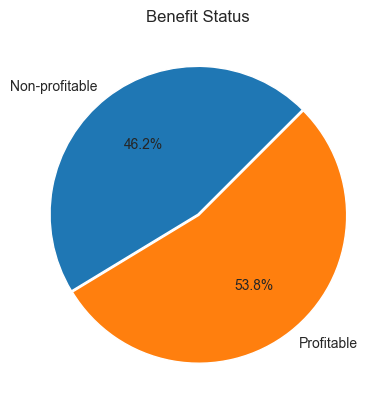

In [22]:
df['benefit_status'].groupby(df["benefit_status"]).count().plot(kind="pie", autopct="%1.1f%%", startangle=45, explode=(0, 0.01))
plt.title("Benefit Status")
plt.ylabel('')
plt.show()

### Popularity

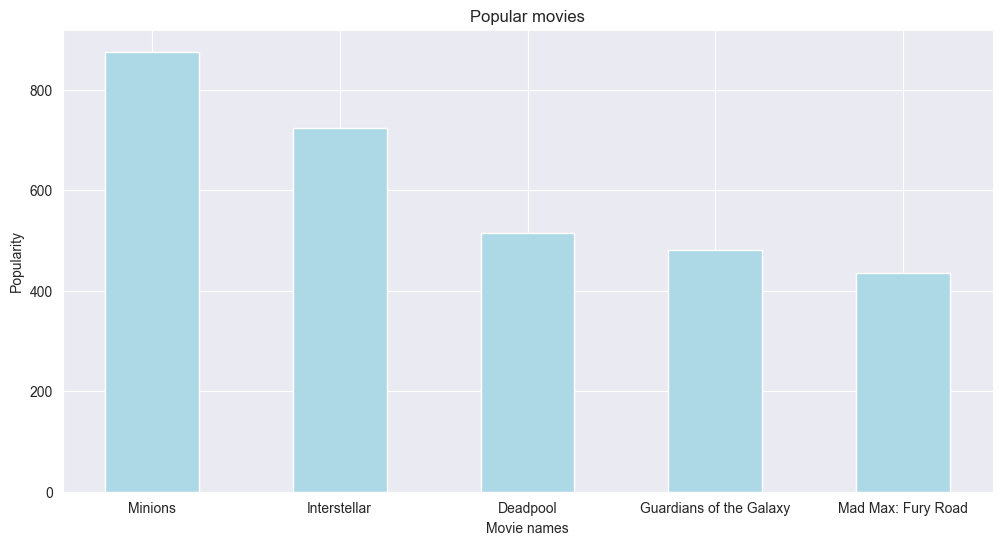

In [23]:
# Sort dataframe based on popularity
popularity = df.sort_values(by=["popularity"], ascending=False)

# Plot top 5 popular movies
plt.figure(figsize=(12, 6))
plt.bar(popularity["title_movies"].head(5), popularity["popularity"].head(5), align="center", width=0.5, color="lightblue")
plt.xlabel("Movie names")
plt.ylabel("Popularity")
plt.title("Popular movies")
plt.show()

In [24]:
df["benefit"].describe()

count    4.803000e+03
mean     5.321560e+07
std      1.359677e+08
min     -1.657101e+08
25%     -7.995375e+05
50%      2.511317e+06
75%      5.531286e+07
max      2.550965e+09
Name: benefit, dtype: float64

## Machine learning

### Changing categorical feature to numeric

In [25]:
# print(f"Label of status of movie : {df['status'].unique()}")
encoder = LabelEncoder()

for feature in df["status"]:
    df["statues_feature"] = encoder.fit_transform(df["status"])

df.head().T
    

,0,1,2,3,4
movie_id,19995,285,206647,49026,49529
title_movies,Avatar,Pirates of the Caribbean: At World's End,Spectre,The Dark Knight Rises,John Carter
cast,"[{'cast_id': 242, 'character': 'Jake Sully', '...","[{'cast_id': 4, 'character': 'Captain Jack Spa...","[{'cast_id': 1, 'character': 'James Bond', 'cr...","[{'cast_id': 2, 'character': 'Bruce Wayne / Ba...","[{'cast_id': 5, 'character': 'John Carter', 'c..."
crew,"[{'credit_id': '52fe48009251416c750aca23', 'de...","[{'credit_id': '52fe4232c3a36847f800b579', 'de...","[{'credit_id': '54805967c3a36829b5002c41', 'de...","[{'credit_id': '52fe4781c3a36847f81398c3', 'de...","[{'credit_id': '52fe479ac3a36847f813eaa3', 'de..."
budget,237000000,300000000,245000000,250000000,260000000
genres,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...","[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...","[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...","[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...","[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam..."
homepage,http://www.avatarmovie.com/,http://disney.go.com/disneypictures/pirates/,http://www.sonypictures.com/movies/spectre/,http://www.thedarkknightrises.com/,http://movies.disney.com/john-carter
keywords,"[{'id': 1463, 'name': 'culture clash'}, {'id':...","[{'id': 270, 'name': 'ocean'}, {'id': 726, 'na...","[{'id': 470, 'name': 'spy'}, {'id': 818, 'name...","[{'id': 849, 'name': 'dc comics'}, {'id': 853,...","[{'id': 818, 'name': 'based on novel'}, {'id':..."
original_language,en,en,en,en,en
original_title,Avatar,Pirates of the Caribbean: At World's End,Spectre,The Dark Knight Rises,John Carter


### Correlation

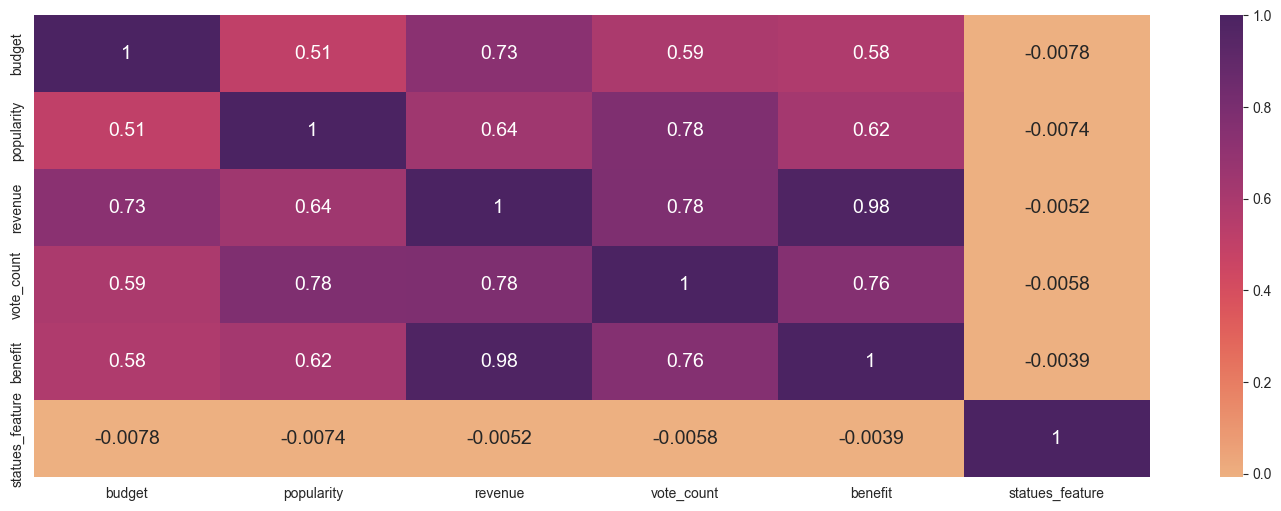

In [26]:
# Correlation of features
df_numerical = df.drop(columns=["movie_id", "title_movies", "cast", "crew", 'genres', 'homepage', "keywords", 'original_language', "original_title", 'overview', "production_countries", "production_companies", "release_date", "spoken_languages", "status", "tagline", "title_credits", 'vote_average', "score", 'runtime', "benefit_status"], axis=1)
fig, ax = plt.subplots( figsize = (18,6) )
corrMatrix = df_numerical.corr()
corrHeatmap = sns.heatmap(corrMatrix, cmap = "flare", annot=True, annot_kws={"size": 14})
plt.show()

In [27]:
#Define features and response

y = df['benefit_status']
X = df.drop(columns=['benefit_status', "benefit", "movie_id", "title_movies", "cast", "crew", 'genres', 'homepage', "keywords", 'original_language', "original_title", 'overview', "production_countries", "production_companies", "release_date", "spoken_languages", "status", "tagline", "title_credits", "budget", "revenue"], axis=1)
X.head()

,popularity,runtime,vote_average,vote_count,score,statues_feature
0,150.437577,162.0,7.2,11800,7.050669,1
1,139.082615,169.0,6.9,4500,6.665696,1
2,107.376788,148.0,6.3,4466,6.239396,1
3,112.312950,165.0,7.6,9106,7.346721,1
4,43.926995,132.0,6.1,2124,6.096368,1


In [28]:
# Scale
scaler = StandardScaler()
X["popularity"] = pd.to_numeric(X["popularity"], errors='coerce').fillna(0).astype(int)
X["runtime"] = pd.to_numeric(X["runtime"], errors='coerce').fillna(0).astype(int)
X["vote_average"] = pd.to_numeric(X["vote_average"], errors='coerce').fillna(0).astype(int)
X["vote_count"] = pd.to_numeric(X["vote_count"], errors='coerce').fillna(0).astype(int)
X["score"] = pd.to_numeric(X["score"], errors='coerce').fillna(0).astype(int)
X["popularity"] = scaler.fit_transform(X["popularity"].values.reshape(-1, 1))
X["runtime"] = scaler.fit_transform(X["runtime"].values.reshape(-1, 1))
X['runtime'] = X['runtime'].fillna(X['runtime'].mean)
X["vote_average"] = scaler.fit_transform(X["vote_average"].values.reshape(-1, 1))
X["vote_count"] = scaler.fit_transform(X["vote_count"].values.reshape(-1, 1))
X["score"] = scaler.fit_transform(X["score"].values.reshape(-1, 1))
y = encoder.fit_transform(y).reshape(-1, 1)
X.head()
# X.info()

,popularity,runtime,vote_average,vote_count,score,statues_feature
0,4.055883,2.429289,1.122229,8.999729,3.013520,1
1,3.710019,2.737526,0.289143,3.086200,0.201409,1
2,2.703868,1.812815,0.289143,3.058657,0.201409,1
3,2.861079,2.561391,1.122229,6.817394,3.013520,1
4,0.691565,1.108273,0.289143,1.161467,0.201409,1


In [29]:
# Define useModel function for all methods
def use_model(model, XData, yData):

    XTrain, XTest, yTrain, yTest = train_test_split(XData, yData, test_size=0.3, random_state=42)

    model = model.fit(XTrain, yTrain)
    yPred = model.predict(XTest)
    print("The Classification report : ")
    print(classification_report(yTest, yPred, zero_division=0))

    # Plotting confusion matrix

    group_names = ['True Negatives (TN)', 'False Positives (FP)\n(Type I Error)',
               'False Negatives (FN)\n(Type II Error)', 'True Positives (TP)']
    group_counts = ['{0:0.0f}'.format(value) for value in confusion_matrix(yTest, yPred).flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in confusion_matrix(yTest, yPred).flatten()/np.sum(confusion_matrix(yTest, yPred))]

    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]

    labels = np.asarray(labels).reshape(2, 2)
    sns.set_palette(sns.color_palette())
    _, ax = plt.subplots(figsize=(6,6))
    ax = sns.heatmap(confusion_matrix(yTest, yPred), annot=labels, fmt='', annot_kws={"size": 12})
    # labels = ['False', 'True']
    # ax.set_xticklabels(labels, fontsize=13);
    # ax.set_yticklabels(labels[::-1], fontsize=13);
    ax.set_ylabel('Prediction', fontsize=13);
    ax.set_xlabel('Ground Truth', fontsize=13)
    ax.set_title("Confusion - Matrix")


    falsePositiveRate, truePositiveRate, threshold = roc_curve(yTest, yPred)
    print('roc_auc_score : ', roc_auc_score(yTest, yPred))

    plt.figure()
    lw = 2
    plt.plot(
     falsePositiveRate,
     truePositiveRate,
     color="darkorange",
     lw=lw,
     label="ROC curve (area = %0.2f)" ,
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic example")
    plt.legend(loc="lower right")
    plt.show()

The Classification report : 
              precision    recall  f1-score   support

           0       0.73      0.71      0.72       651
           1       0.77      0.79      0.78       790

    accuracy                           0.75      1441
   macro avg       0.75      0.75      0.75      1441
weighted avg       0.75      0.75      0.75      1441

roc_auc_score :  0.7471086352058178


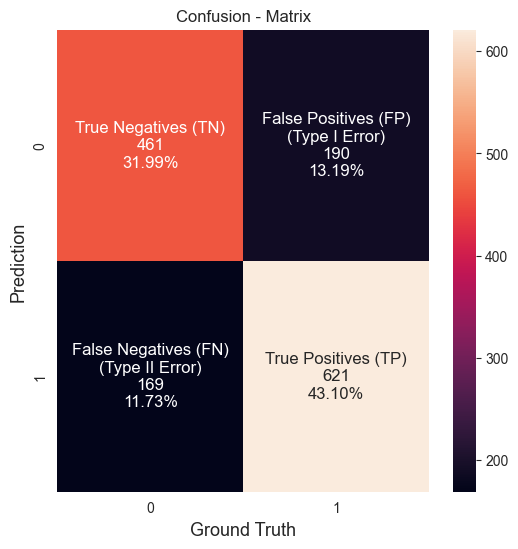

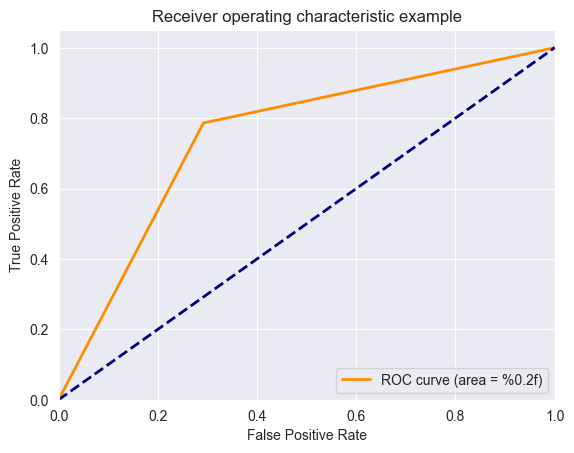

In [30]:
use_model(KNeighborsClassifier(n_neighbors=3), X, y)

The Classification report : 
              precision    recall  f1-score   support

           0       0.69      0.71      0.70       651
           1       0.75      0.74      0.75       790

    accuracy                           0.72      1441
   macro avg       0.72      0.72      0.72      1441
weighted avg       0.72      0.72      0.72      1441

roc_auc_score :  0.7221548153765385


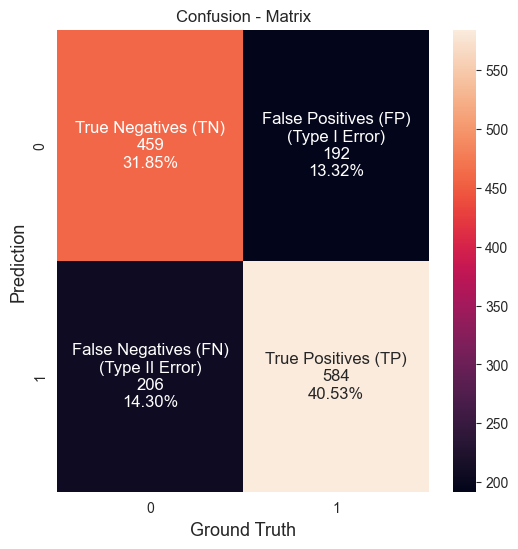

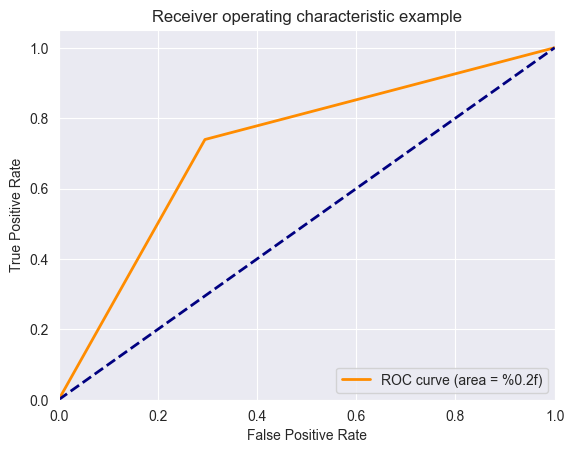

In [31]:
use_model(DecisionTreeClassifier(), X, y)

The Classification report : 
              precision    recall  f1-score   support

           0       0.74      0.75      0.75       651
           1       0.79      0.79      0.79       790

    accuracy                           0.77      1441
   macro avg       0.77      0.77      0.77      1441
weighted avg       0.77      0.77      0.77      1441

roc_auc_score :  0.7693820607050497


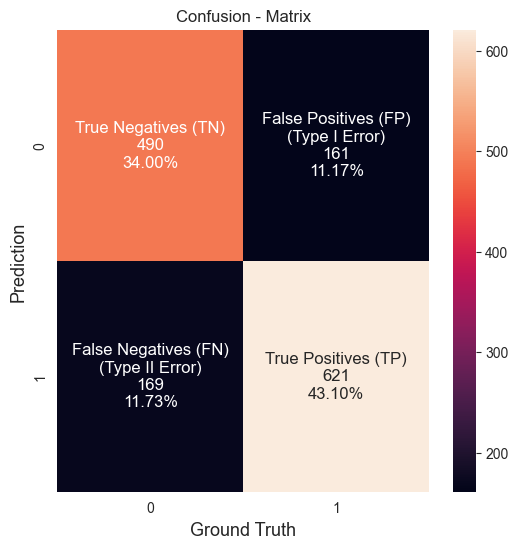

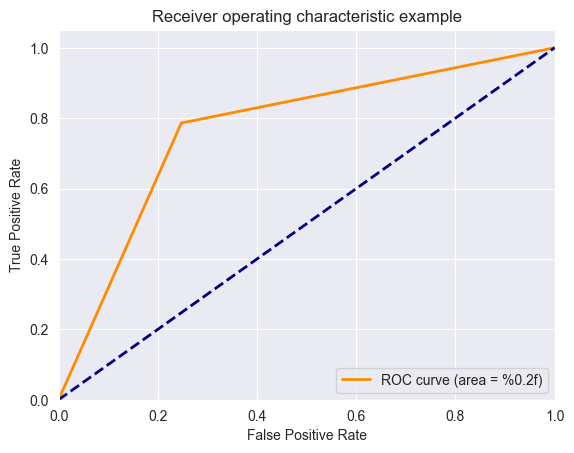

In [32]:
use_model(RandomForestClassifier(), X, y)

The Classification report : 
              precision    recall  f1-score   support

           0       0.70      0.77      0.73       651
           1       0.79      0.73      0.76       790

    accuracy                           0.75      1441
   macro avg       0.75      0.75      0.75      1441
weighted avg       0.75      0.75      0.75      1441

roc_auc_score :  0.7484464018355403


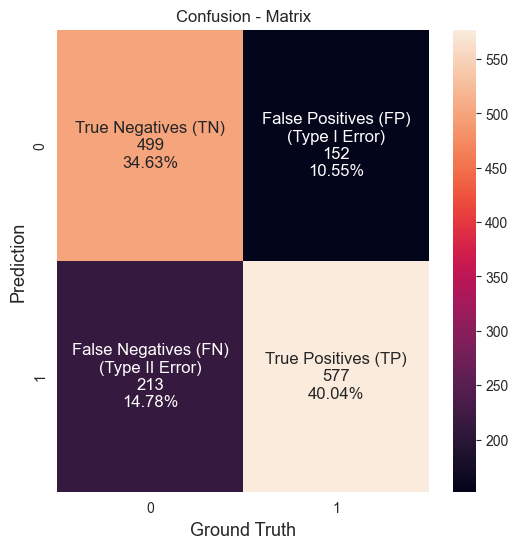

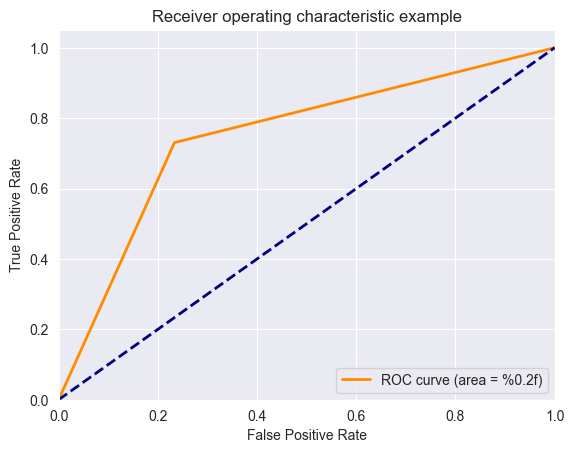

In [33]:
use_model(BaggingClassifier(), X, y)


The Classification report : 
              precision    recall  f1-score   support

           0       0.74      0.73      0.74       651
           1       0.78      0.78      0.78       790

    accuracy                           0.76      1441
   macro avg       0.76      0.76      0.76      1441
weighted avg       0.76      0.76      0.76      1441

roc_auc_score :  0.7595325594508935


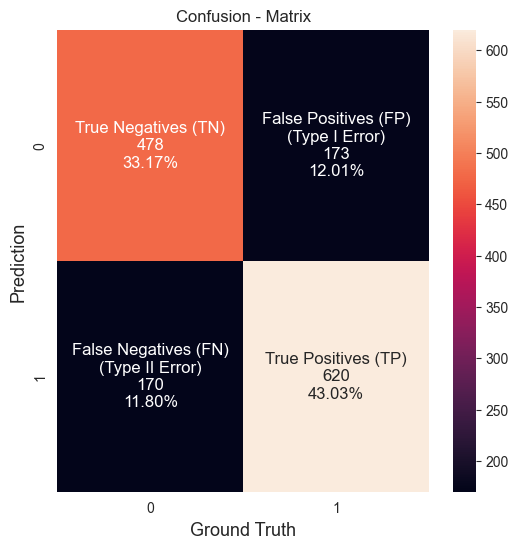

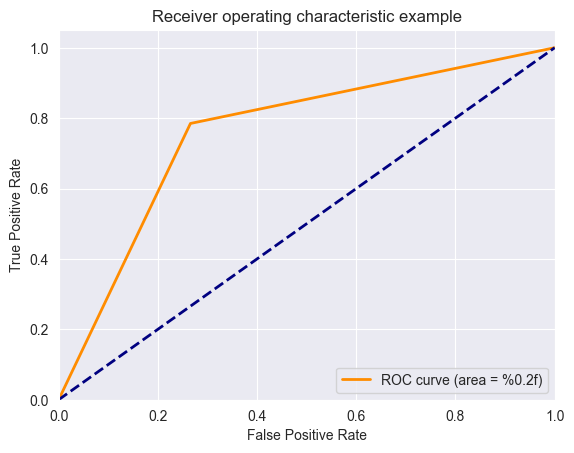

In [34]:
use_model(ExtraTreesClassifier(), X, y)


The Classification report : 
              precision    recall  f1-score   support

           0       0.74      0.83      0.78       651
           1       0.84      0.75      0.80       790

    accuracy                           0.79      1441
   macro avg       0.79      0.79      0.79      1441
weighted avg       0.79      0.79      0.79      1441

roc_auc_score :  0.7920968714149604


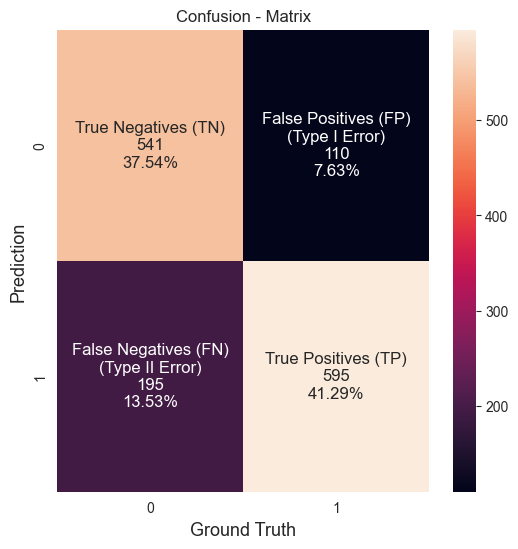

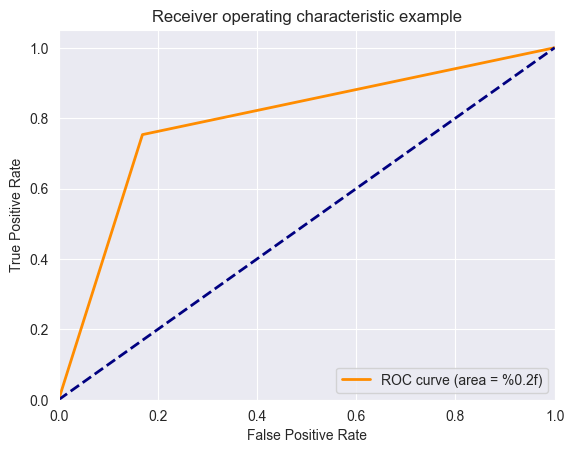

In [35]:
use_model(LogisticRegression(),X, y)


The Classification report : 
              precision    recall  f1-score   support

           0       0.74      0.74      0.74       651
           1       0.79      0.78      0.78       790

    accuracy                           0.76      1441
   macro avg       0.76      0.76      0.76      1441
weighted avg       0.76      0.76      0.76      1441

roc_auc_score :  0.7628750315969589


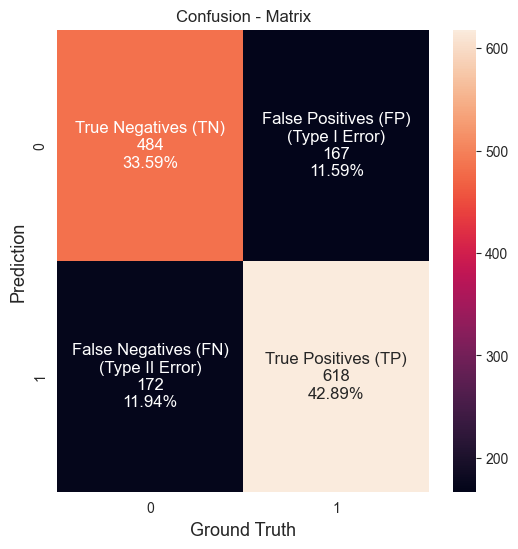

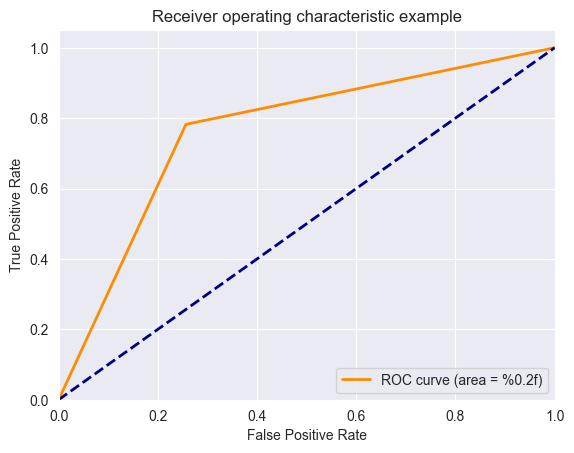

In [36]:
use_model(XGBClassifier(),X, y)

#### Choosing model


In [37]:
# Checking train and test accuracy
def get_accuracy(XData, yData, model):

    XTrain, XTest, yTrain, yTest = train_test_split(XData, yData, test_size=0.3, random_state=42)

    model = model.fit(XTrain, yTrain)
    y_pred = model.predict(XTest)
    print("Test Accuracy : ", accuracy_score(yTest, y_pred))
    print("Train Accuracy : ", accuracy_score(yTrain, model.predict(XTrain)))

In [38]:
# Logistic Regression is the best classifier, So here the accuracy
get_accuracy(X, y, LogisticRegression())

Test Accuracy :  0.7883414295628036
Train Accuracy :  0.7739440809042237


In [39]:
# Parameter tuning

param_dist = {
    'penalty': ['l1', 'l2'],
'C': [1 , 0.5, 0.1, 0.05, 0.01],
'class_weight': ['balanced', None],
'solver': ['liblinear', 'lbfgs'],
'max_iter': [100,200,300]
}

model = LogisticRegression()

search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, scoring='accuracy', cv=3, n_iter=10)#, error_score="raise")
search.fit(X, y)

RandomizedSearchCV(cv=3, estimator=LogisticRegression(),
                   param_distributions={'C': [1, 0.5, 0.1, 0.05, 0.01],
                                        'class_weight': ['balanced', None],
                                        'max_iter': [100, 200, 300],
                                        'penalty': ['l1', 'l2'],
                                        'solver': ['liblinear', 'lbfgs']},
                   scoring='accuracy')

In [40]:
# Getting the best hyperparameters
best_params = search.best_params_
best_params

{'solver': 'lbfgs',
 'penalty': 'l2',
 'max_iter': 300,
 'class_weight': None,
 'C': 1}

#### Feature Importance with Logistic Regression


In [41]:
gr_LR_model = LogisticRegression(solver="lbfgs", penalty="l2", max_iter=200, class_weight=None, C=0.1)
gr_LR_model.fit(X, y)

LogisticRegression(C=0.1, max_iter=200)

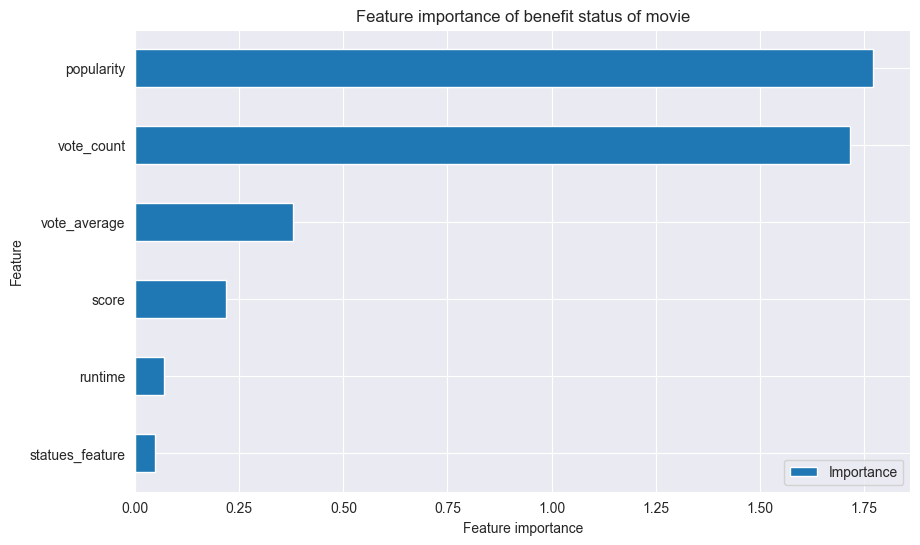

In [42]:
coefficients = gr_LR_model.coef_[0]

feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))
plt.xlabel('Feature importance')
plt.title('Feature importance of benefit status of movie')
plt.show()


The Classification report : 
              precision    recall  f1-score   support

           0       0.74      0.83      0.78       651
           1       0.84      0.76      0.80       790

    accuracy                           0.79      1441
   macro avg       0.79      0.79      0.79      1441
weighted avg       0.80      0.79      0.79      1441

roc_auc_score :  0.7925946450446246


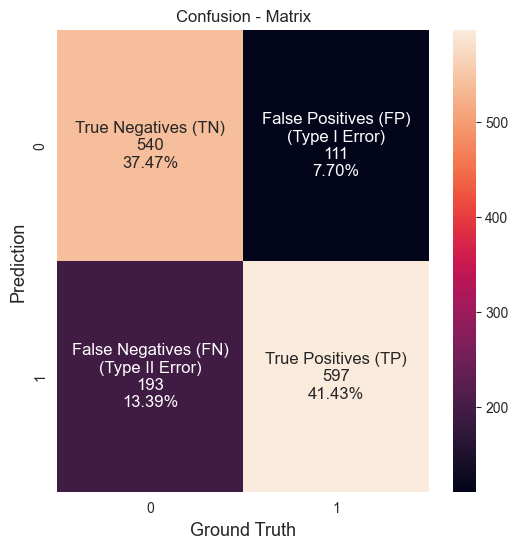

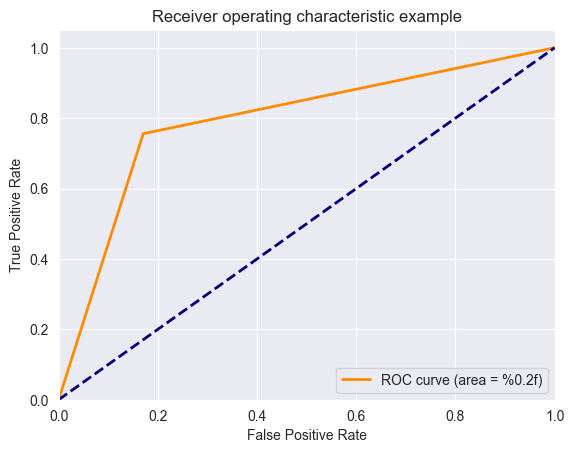

In [43]:
# New Predictions Based on features that have importance

X_prediction = X[["popularity", "vote_count", "vote_average", "score"]]

use_model(LogisticRegression(), X_prediction, y)